In [635]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers, matrix
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [636]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

In [637]:
return_vec

array([[-1.0856306 ,  0.99734545,  0.2829785 , ..., -0.90932702,
         0.47026375, -1.11143045],
       [-0.74882747,  0.56759473,  0.71815054, ..., -0.35929672,
        -1.60969508,  0.01357006],
       [-1.77422355, -1.20137731,  1.09625679, ...,  2.04043199,
         1.01591697, -1.63378817],
       [-0.45059869,  0.60959032,  1.17374438, ..., -0.1227329 ,
         1.79448602, -0.32050951]])

Text(0, 0.5, 'returns')

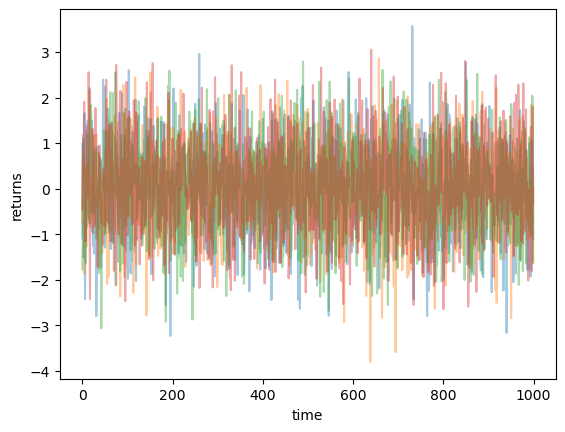

In [638]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [639]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)



In [640]:
print (rand_weights(n_assets))
print (rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [641]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [642]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

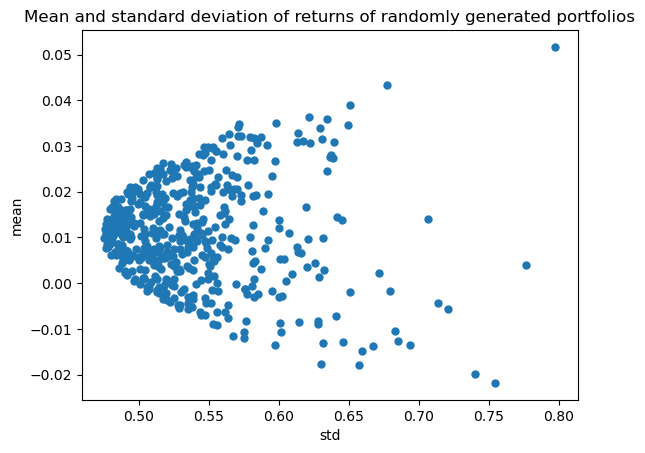

In [643]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [644]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 50
    lambdas = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    ret_vec = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(lbd*S, ret_vec, G, h, A, b)['x'] 
                  for lbd in lambdas ]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(ret_vec, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), ret_vec, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


## Backtesting on real market data

##### First, lets load in some historical data using Quantopian's data (if we are running in the Quantopian Research Platform, or the load_bars_from_yahoo() function from zipline.

In [645]:
import yfinance as yf

aapl= yf.Ticker("aapl")
aapl

yfinance.Ticker object <AAPL>

In [646]:
df = yf.download("KLAC AMD MSFT ADSK TXN", start="2022-01-01",
                    end="2022-12-31", group_by='tickers')
df


[*********************100%***********************]  5 of 5 completed


AMD                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2022-01-03  145.139999  151.649994  145.020004  150.240005  150.240005   
2022-01-04  151.009995  152.419998  140.699997  144.419998  144.419998   
2022-01-05  142.820007  143.759995  135.289993  136.149994  136.149994   
2022-01-06  136.190002  138.000000  131.770004  136.229996  136.229996   
2022-01-07  136.279999  137.440002  131.130005  132.000000  132.000000   
...                ...         ...         ...         ...         ...   
2022-12-23   63.110001   64.660004   62.720001   64.519997   64.519997   
2022-12-27   63.869999   64.279999   62.970001   63.270000   63.270000   
2022-12-28   62.540001   63.540001   61.959999   62.570000   62.570000   
2022-12-29   63.639999   65.180000   63.060001   64.820000   64.820000   
2022-12-30   63.770000   64.820000   63.139999   64.769997   64.769997   

                            MSFT                                      ...  \
              Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2022-01-03  59396600  335.350006  338.000000  329.779999  334.750000  ...   
2022-01-04  80200500  334.829987  335.200012  326.119995  329.010010  ...   
2022-01-05  65403200  325.859985  326.070007  315.980011  316.380005  ...   
2022-01-06  64802900  313.149994  318.700012  311.489990  313.880005  ...   
2022-01-07  58441100  314.149994  316.500000  310.089996  314.040009  ...   
...              ...         ...         ...         ...         ...  ...   
2022-12-23  45923000  236.110001  238.869995  233.940002  238.729996  ...   
2022-12-27  36086000  238.699997  238.929993  235.830002  236.960007  ...   
2022-12-28  39526500  236.889999  239.720001  234.169998  234.529999  ...   
2022-12-29  41428500  235.649994  241.919998  235.649994  241.009995  ...   
2022-12-30  37099800  238.210007  239.960007  236.660004  239.820007  ...   

                   TXN                                         KLAC  \
                   Low       Close   Adj Close   Volume        Open   
Date                                                                  
2022-01-03  187.460007  190.600006  185.358856  3781500  431.140015   
2022-01-04  188.199997  190.800003  185.553360  4137500  434.380005   
2022-01-05  186.649994  186.820007  181.682800  5047400  432.160004   
2022-01-06  185.789993  186.759995  181.624435  4502600  420.630005   
2022-01-07  178.899994  179.440002  174.505737  7414200  429.809998   
...                ...         ...         ...      ...         ...   
2022-12-23  162.279999  164.380005  164.380005  2597000  372.239990   
2022-12-27  161.970001  163.779999  163.779999  3535600  376.260010   
2022-12-28  160.830002  161.190002  161.190002  2998600  369.309998   
2022-12-29  162.820007  165.020004  165.020004  4081600  373.140015   
2022-12-30  162.210007  165.220001  165.220001  3249000  374.549988   

                                                                     
                  High         Low       Close   Adj Close   Volume  
Date                                                                 
2022-01-03  435.640015  425.609985  435.089996  429.492249  1044300  
2022-01-04  436.839996  417.600006  431.239990  425.691772   964900  
2022-01-05  435.089996  419.679993  420.739990  415.326874  1174000  
2022-01-06  435.049988  417.769989  432.220001  426.659180  1268500  
2022-01-07  435.529999  416.190002  416.910004  411.546173  1155000  
...                ...         ...         ...         ...      ...  
2022-12-23  378.000000  367.720001  377.390015  377.390015   892000  
2022-12-27  376.260010  368.859985  371.100006  371.100006   988700  
2022-12-28  375.480011  366.320007  367.760010  367.760010   610400  
2022-12-29  381.359985  372.739990  379.859985  379.859985   787200 

In [647]:
df.axes

[DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
                '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
                '2022-01-13', '2022-01-14',
                ...
                '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
                '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
                '2022-12-29', '2022-12-30'],
               dtype='datetime64[ns]', name='Date', length=251, freq=None),
 MultiIndex([( 'AMD',      'Open'),
             ( 'AMD',      'High'),
             ( 'AMD',       'Low'),
             ( 'AMD',     'Close'),
             ( 'AMD', 'Adj Close'),
             ( 'AMD',    'Volume'),
             ('MSFT',      'Open'),
             ('MSFT',      'High'),
             ('MSFT',       'Low'),
             ('MSFT',     'Close'),
             ('MSFT', 'Adj Close'),
             ('MSFT',    'Volume'),
             ('ADSK',      'Open'),
             ('ADSK',      'High'),
             ('ADSK',  

In [648]:

df = df.stack(level=1).rename_axis(['Date','Attribute']).reset_index(level=1)
df=df.loc[df['Attribute']=='Adj Close']
df

,Attribute,ADSK,AMD,KLAC,MSFT,TXN
Date,,,,,,
2022-01-03,Adj Close,283.720001,150.240005,429.492249,331.642426,185.358856
2022-01-04,Adj Close,278.190002,144.419998,425.691772,325.955750,185.553360
2022-01-05,Adj Close,264.320007,136.149994,415.326874,313.442993,181.682800
2022-01-06,Adj Close,264.109985,136.229996,426.659180,310.966187,181.624435
2022-01-07,Adj Close,262.320007,132.000000,411.546173,311.124695,174.505737
...,...,...,...,...,...,...
2022-12-23,Adj Close,188.160004,64.519997,377.390015,238.729996,164.380005
2022-12-27,Adj Close,186.289993,63.270000,371.100006,236.960007,163.779999
2022-12-28,Adj Close,181.899994,62.570000,367.760010,234.529999,161.190002


Text(0, 0.5, 'price in $')

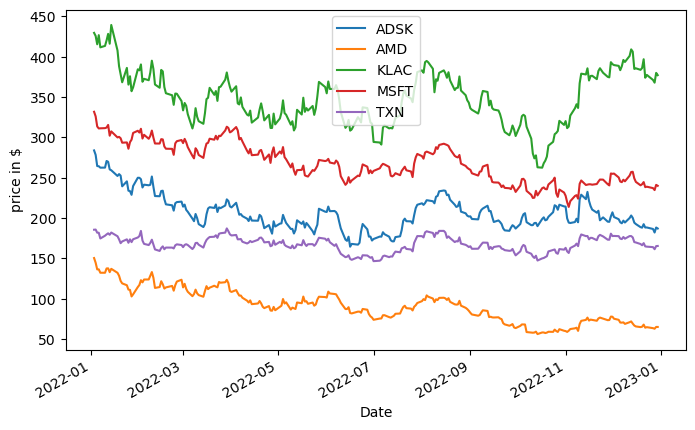

In [649]:
df.loc[:, :].plot(figsize=(8,5))
plt.ylabel('price in $')

In [650]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [651]:
df=df.drop(['Attribute'], axis=1)

In [652]:

returns=df.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [653]:
returns

,ADSK,AMD,KLAC,MSFT,TXN
Date,,,,,
2022-01-04,-0.019491,-0.038738,-0.008849,-0.017147,0.001049
2022-01-05,-0.049858,-0.057264,-0.024348,-0.038388,-0.020860
2022-01-06,-0.000795,0.000588,0.027285,-0.007902,-0.000321
2022-01-07,-0.006777,-0.031050,-0.035422,0.000510,-0.039195
2022-01-10,0.000267,0.000000,0.004365,0.000732,0.019617
...,...,...,...,...,...
2022-12-23,0.000319,0.010335,0.009469,0.002267,-0.001943
2022-12-27,-0.009938,-0.019374,-0.016667,-0.007414,-0.003650
2022-12-28,-0.023565,-0.011064,-0.009000,-0.010255,-0.015814


In [654]:
np.mean(returns, axis=0)

ADSK   -0.001221
AMD    -0.002621
KLAC   -0.000048
MSFT   -0.001049
TXN    -0.000256
dtype: float64

In [655]:
np.std(returns)

ADSK    0.030096
AMD     0.038382
KLAC    0.030755
MSFT    0.022244
TXN     0.020176
dtype: float64

In [656]:
def optimal_portfolio(returns):
    n = 5
    returns = np.asmatrix(returns)
    N = 1000
    lambdas = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns.T))
    ret_vec = opt.matrix(np.mean(returns, axis=0)).T

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(lbd*S, -ret_vec, G, h, A, b)['x'] 
                    for lbd in lambdas ]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(ret_vec.T, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -ret_vec, G, h, A, b)['x']
    return np.asarray(wt), returns, risks,portfolios

In [657]:
weights, returns, risks,portfolios = optimal_portfolio(returns)

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

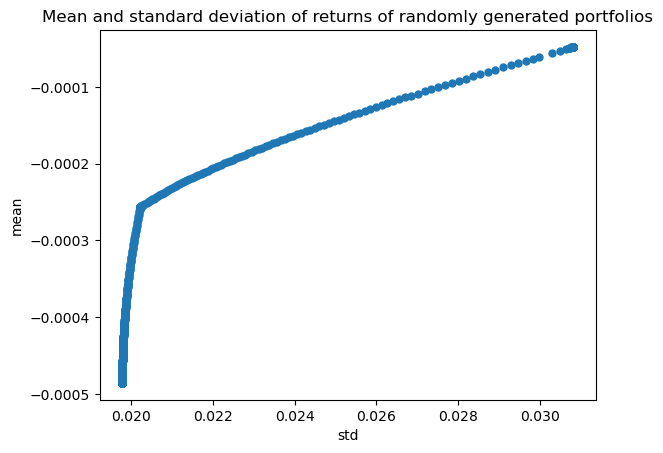

In [658]:


plt.plot(risks, returns, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [659]:
weights

array([[5.14201551e-06],
       [5.07147831e-06],
       [9.99977228e-01],
       [3.42955810e-06],
       [9.12860707e-06]])

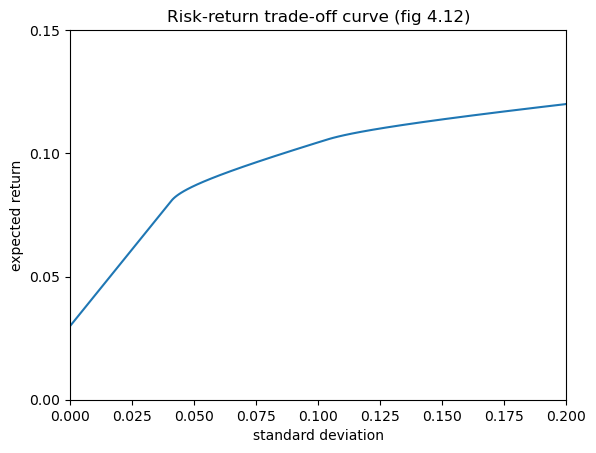

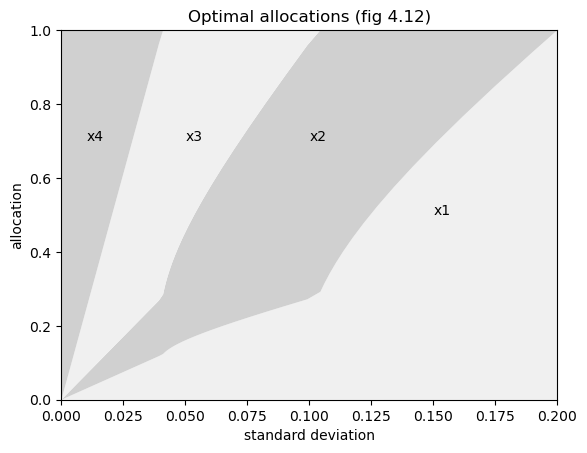

In [157]:
# Figure 4.12, page 187.
# Risk-return trade-off.

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

n = 4
S = matrix( [[ 4e-2,  6e-3, -4e-3,   0.0 ],
             [ 6e-3,  1e-2,  0.0,    0.0 ],
             [-4e-3,  0.0,   2.5e-3, 0.0 ],
             [ 0.0,   0.0,   0.0,    0.0 ]] )
pbar = matrix([.12, .10, .07, .03])

G = matrix(0.0, (n,n))
G[::n+1] = -1.0
h = matrix(0.0, (n,1))
A = matrix(1.0, (1,n))
b = matrix(1.0)

N = 100
mus = [ 10**(5.0*t/N-1.0) for t in range(N) ]
options['show_progress'] = False
xs = [ qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus ]
returns = [ dot(pbar,x) for x in xs ]
risks = [ sqrt(dot(x, S*x)) for x in xs ]

try: import pylab
except ImportError: pass
else:
    pylab.figure(1, facecolor='w')
    pylab.plot(risks, returns)
    pylab.xlabel('standard deviation')
    pylab.ylabel('expected return')
    pylab.axis([0, 0.2, 0, 0.15])
    pylab.title('Risk-return trade-off curve (fig 4.12)')
    pylab.yticks([0.00, 0.05, 0.10, 0.15])

    pylab.figure(2, facecolor='w')
    c1 = [ x[0] for x in xs ]
    c2 = [ x[0] + x[1] for x in xs ]
    c3 = [ x[0] + x[1] + x[2] for x in xs ]
    c4 = [ x[0] + x[1] + x[2] + x[3] for x in xs ]
    pylab.fill(risks + [.20], c1 + [0.0], facecolor = '#F0F0F0')
    pylab.fill(risks[-1::-1] + risks, c2[-1::-1] + c1,
        facecolor = '#D0D0D0')
    pylab.fill(risks[-1::-1] + risks, c3[-1::-1] + c2,
        facecolor = '#F0F0F0')
    pylab.fill(risks[-1::-1] + risks, c4[-1::-1] + c3,
        facecolor = '#D0D0D0')
    pylab.axis([0.0, 0.2, 0.0, 1.0])
    pylab.xlabel('standard deviation')
    pylab.ylabel('allocation')
    pylab.text(.15,.5,'x1')
    pylab.text(.10,.7,'x2')
    pylab.text(.05,.7,'x3')
    pylab.text(.01,.7,'x4')
    pylab.title('Optimal allocations (fig 4.12)')
    pylab.show()